In [1]:
import numpy as np
import gym
import gym_game
import random
import matplotlib.pyplot as plt

C:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from gym_game.envs.memory_task import check_point, begin_location

pygame 2.1.2 (SDL 2.0.18, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
env = gym.make("MemTask-v0", task_image='task2.png')

In [4]:
# while True:
#     env.reset()
#     env.step(0)
#     env.render()

## A2C_LSTM_EM

In [5]:
from model import A2C_LSTM_EM as Agent
from model import compute_a2c_loss
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def compute_returns(rewards, gamma=0, normalize=False):
    """compute return in the standard policy gradient setting.
    Parameters
    ----------
    rewards : list
        list of rewards
    gamma : float
        discount factor
    normalize : bool
        whether to normalize the return
    Returns
    -------
    torch.tensor, torch.tensor
        Description of returned object.
    """
    returns = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns, returns.sum()

In [7]:
compute_returns([0,0,1,3,5,12], gamma=0.99)

(tensor([20.1059, 20.3089, 20.5141, 19.7112, 16.8800, 12.0000]),
 tensor(109.5201))

In [8]:
learning_rate = 4e-5
dim_hidden = 200
# init agent / optimizer
agent = Agent(env.observation_space.shape[0], dim_hidden, env.action_space.n, episode_len=70)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate, weight_decay=1e-5)

In [9]:
# agent.load_state_dict(torch.load('./model/A2C_LSTM_Episodic_MemTask_400Trials.pth'))
# agent.eval()

In [10]:
n_trials = 600
trial_length = 72

In [11]:
h1 = np.zeros((n_trials, trial_length, dim_hidden))
c1 = np.zeros((n_trials, trial_length, dim_hidden))
h2 = np.zeros((n_trials, trial_length, dim_hidden))
c2 = np.zeros((n_trials, trial_length, dim_hidden))
a = np.zeros((n_trials, trial_length))
r = np.zeros((n_trials, trial_length))
trial_types = np.zeros((n_trials))
trial_reward = np.zeros((n_trials))

In [12]:
# for g in optimizer.param_groups:
#     g['lr'] = 1e-1

In [13]:
state = env.reset()
for i in range(48):
    state, reward, done, _ = env.step(0);

In [14]:
x_t = torch.tensor(state).float().view(1, 1, -1);
x_t = x_t.reshape(45, -1)

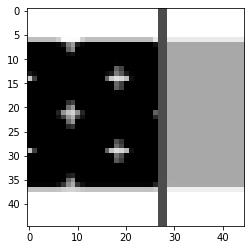

In [15]:
plt.imshow(x_t, cmap='gray');

In [23]:
def simulate(n_trials):
    
    for episode in range(n_trials):

        h1_t, c1_t, h2_t, c2_t = agent.get_init_states(scale=0)

        # Init environment
        state = env.reset()

        probs, rewards, values = [], [], []

        agent.alpha = 1.0 # blend LSTM hidden state and attention on episodic_memory (EM) output
        if episode % 10 == 0:
            allow_LSTM_backprop = False
        else:
            allow_LSTM_backprop = False

        # AI tries up to MAX_TRY times
        for t in range(trial_length):

            # A2C agent picks action
            x_t = torch.tensor(state).float().view(1, 1, -1) # .view(1,1,-1) for LSTM input with (seq_len, batch, input_size)
            a_dist, value, h1_t, c1_t, h2_t, c2_t = agent(
                x_t, h1_t, c1_t, h2_t, c2_t, beta=1, allow_hidden_backprop=allow_LSTM_backprop)
            action, action_prob, entropy = agent.pick_action(a_dist, noise_level=0) # noise_level is 8e-3 at 6th session

            # Do action and get result
            next_state, reward, done, _ = env.step(action)
            probs.append(action_prob)
            rewards.append(reward)
            values.append(value)

            # Record fast (h) and slow (c) states in LSTMs
            h1[episode, t, :]   = h1_t.detach().numpy().flatten()
            c1[episode, t, :]   = c1_t.detach().numpy().flatten()
            a[episode, t]      = 0 if action.detach().item() != 0 else 1
            r[episode, t]      = 0 if reward <=0 else 1

            if t%5 != 1:
                h2_t, c2_t = None, None
            else:
                h2[episode, t, :]   = h2_t.detach().numpy().flatten()
                c2[episode, t, :]   = c2_t.detach().numpy().flatten()

            # Set up game state for the next iteration
            state = next_state
            # Draw games
            env.render()
            # When episode is done, print reward
            if done or t >= trial_length - 1:
                agent.reset_episodic_mem(scale=0)
                if sum(rewards) == 0:
                    rewards = [-10] * len(rewards)
                print("Episode %d finished after %i time steps with total reward = %f." % (episode, t, sum(rewards)))
                break

        trial_types[episode] = 0 if env.env.task_env.trial_type == 'T1' else 1
        trial_reward[episode] = sum(rewards)

        returns, _ = compute_returns(rewards, gamma=0.0, normalize=False)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        if episode % 1 == 0:
            loss = loss_policy + loss_value
        else:
            loss = loss_value
        print(loss)
        # loss = pos_loss
        nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return episode, int(trial_types[episode]), sum(rewards)


In [24]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

agent.episodic_Att.apply(init_weights)

C:\Users\labadmin\AppData\Local\Temp/ipykernel_22584/3156721728.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Sequential(
  (0): Linear(in_features=2025, out_features=70, bias=True)
)

In [25]:
for g in optimizer.param_groups:
    g['lr'] = 4e-6

In [26]:
n_trials

600

In [27]:
# while True:
simulate(n_trials)

Episode 0 finished after 71 time steps with total reward = -700.000000.
tensor(2010.5647, grad_fn=<AddBackward0>)
Episode 1 finished after 71 time steps with total reward = -700.000000.
tensor(43.6108, grad_fn=<AddBackward0>)
Episode 2 finished after 71 time steps with total reward = 800.000000.
tensor(1834.2909, grad_fn=<AddBackward0>)
Episode 3 finished after 71 time steps with total reward = 300.000000.
tensor(1649.2362, grad_fn=<AddBackward0>)
Episode 4 finished after 71 time steps with total reward = -1300.000000.
tensor(-140.4126, grad_fn=<AddBackward0>)
Episode 5 finished after 71 time steps with total reward = -1000.000000.
tensor(642.9489, grad_fn=<AddBackward0>)
Episode 6 finished after 71 time steps with total reward = -1000.000000.
tensor(37.9865, grad_fn=<AddBackward0>)
Episode 7 finished after 71 time steps with total reward = -1100.000000.
tensor(936.4967, grad_fn=<AddBackward0>)
Episode 8 finished after 71 time steps with total reward = -720.000000.
tensor(473.2250, gra

KeyboardInterrupt: 

In [12]:
# agent.actorOutput.reset_parameters()
# agent.episodic_Att[0].reset_parameters()
# agent.critic.reset_parameters()
# agent.actorLSTM.reset_parameters()
# agent.position_LSTM.reset_parameters()

In [13]:
# env.env.task_image = 'task1.png'

In [18]:
n_trials = []
n_sessions = 1
for i in range(n_sessions):
    flag = [0, 0]
    n_trial = 0

    # training and return how many trials agent learns (n_trial)
    while True:
        episode, trial_type, reward = simulate(1)
        print(n_trial, trial_type, reward)
        if reward>=1800:
            flag[trial_type] += 1
        if flag[0] > 15 and flag[1] > 15:
            break
        n_trial += (episode+1)
        if n_trial > 600:
            break
    
    print(n_trial)
    n_trials.append(n_trial)

    # reverse the rule then start the next session
    check_point['T1'], check_point['T2'] = check_point['T2'], check_point['T1'] 

Episode 0 finished after 71 time steps with total reward = 675.000000.
tensor(3032.4834, grad_fn=<AddBackward0>)
0 1 675
Episode 0 finished after 71 time steps with total reward = 1275.000000.
tensor(4509.6436, grad_fn=<AddBackward0>)
1 1 1275
Episode 0 finished after 71 time steps with total reward = 1050.000000.
tensor(3019.3081, grad_fn=<AddBackward0>)
2 1 1050
Episode 0 finished after 71 time steps with total reward = 1050.000000.
tensor(3002.5852, grad_fn=<AddBackward0>)
3 0 1050
Episode 0 finished after 71 time steps with total reward = 1275.000000.
tensor(3742.3606, grad_fn=<AddBackward0>)
4 1 1275
Episode 0 finished after 71 time steps with total reward = 1500.000000.
tensor(2622.7090, grad_fn=<AddBackward0>)
5 1 1500
Episode 0 finished after 71 time steps with total reward = 1575.000000.
tensor(3198.3950, grad_fn=<AddBackward0>)
6 1 1575
Episode 0 finished after 71 time steps with total reward = 1575.000000.
tensor(4481.6621, grad_fn=<AddBackward0>)
7 1 1575
Episode 0 finished

In [17]:
n_trials

[353, 246, 577, 140, 394, 601, 380, 601]

In [15]:
n_trials

[430, 250, 122, 232, 511, 387, 347, 314, 601, 601]

In [15]:
n_trials 

[463, 202, 484, 220, 601, 421, 100, 160, 222, 263]

In [20]:
n_trials

[601, 225, 301, 601, 357, 247, 405, 238, 320, 601]

In [18]:
n_trials

[331, 220, 102, 320, 112, 349, 235, 399]

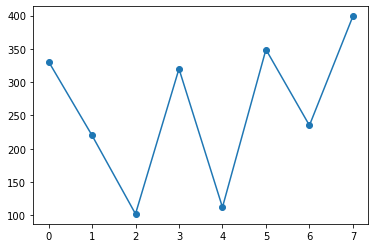

In [17]:
plt.plot(n_trials, '-o')

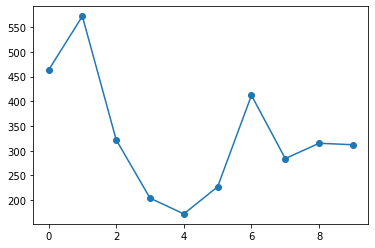

In [53]:
plt.plot([463, 572, 322, 204, 172, 227, 267+145, 284, 315, 312], '-o')

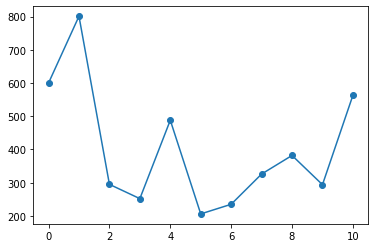

In [73]:
plt.plot([524, 801, 295, 252, 488, 206, 235, 326, 382, 294, 563], '-o');

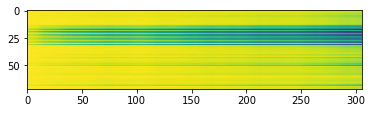

In [34]:
plt.imshow(h1[np.where(trial_types==0)[0][:], :, 5].T);

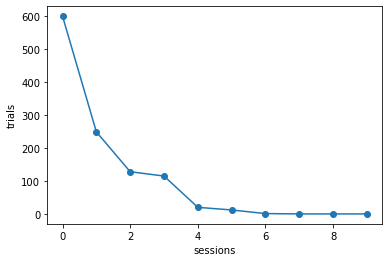

In [18]:
plt.plot([600, 249, 128, 115, 20, 12, 1, 0, 0, 0] , '-o');
plt.ylabel('trials');
plt.xlabel('sessions');

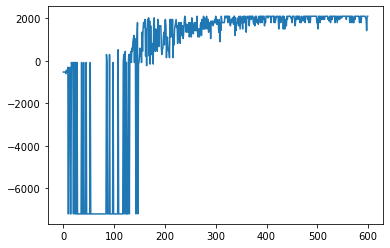

In [19]:
plt.plot(trial_reward)

In [20]:
# torch.save(agent.state_dict(), './data/meta/A2C_FS_LSTM_META.pth')

In [21]:
print(h1.shape, c1.shape, r.shape, a.shape)

(600, 72, 160) (600, 72, 160) (600, 72) (600, 72)


In [22]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


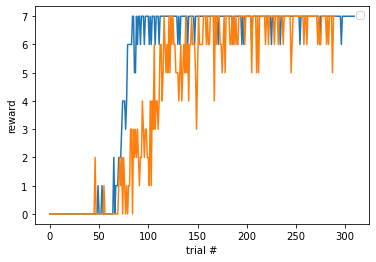

In [23]:
plt.plot(r[trial_types == 0].sum(axis=1))
plt.plot(r[trial_types == 1].sum(axis=1))
plt.legend();
plt.xlabel('trial #');
plt.ylabel('reward');

In [13]:
pcorr = np.zeros(((n_trials-1)//2, trial_length-1))
for i in range(n_trials-1):
    for j in range(trial_length-1):
        try:
            pcorr[i,j] = np.corrcoef(h1[np.where(trial_types==1)[0][i], j, :], h1[np.where(trial_types==0)[0][i], j, :])[0,1]
        except:
            pass

C:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


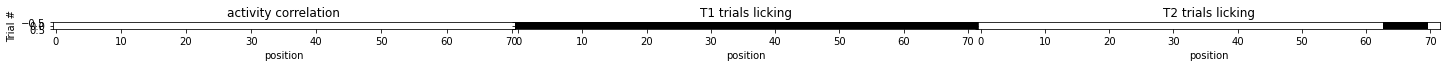

In [14]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,8))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.0001)
ax[0].set_title('activity correlation')
ax[0].imshow(pcorr[:, :], cmap='bwr');
ax[0].set_ylabel('Trial #');
ax[0].set_xlabel('position');
ax[1].set_title('T1 trials licking')
ax[1].imshow(a[trial_types==0], cmap='gray');
ax[1].set_xlabel('position');
ax[2].set_title('T2 trials licking')
ax[2].imshow(a[trial_types==1], cmap='gray');
ax[2].set_xlabel('position');
# ax[0].set_ylim(10,100)

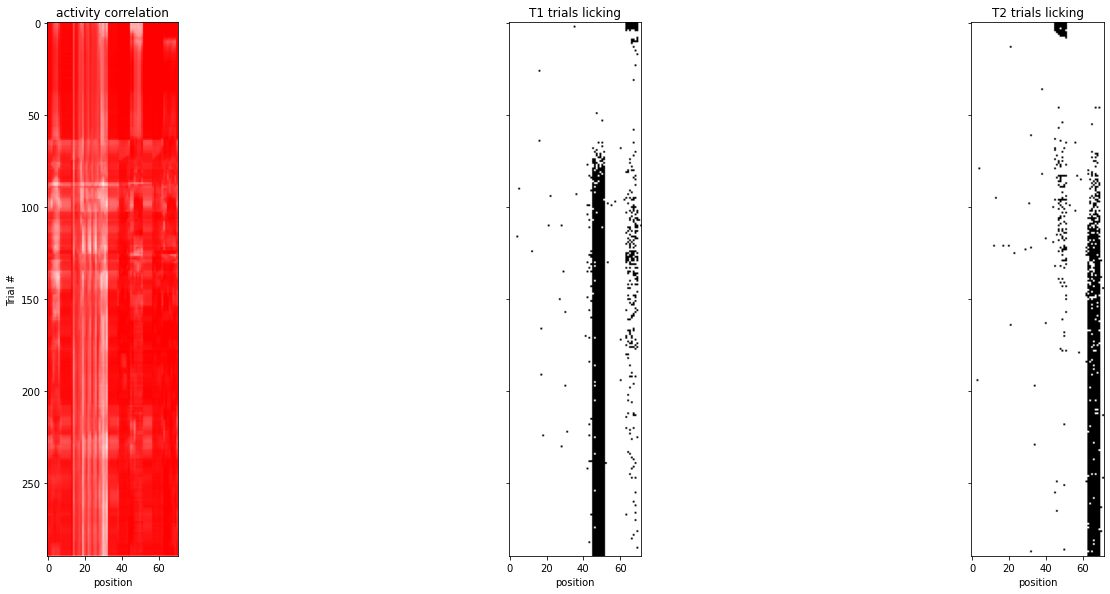

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,8))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.0001)
ax[0].set_title('activity correlation')
ax[0].imshow(pcorr[:, :], cmap='bwr');
ax[0].set_ylabel('Trial #');
ax[0].set_xlabel('position');
ax[1].set_title('T1 trials licking')
ax[1].imshow(a[trial_types==0], cmap='gray');
ax[1].set_xlabel('position');
ax[2].set_title('T2 trials licking')
ax[2].imshow(a[trial_types==1], cmap='gray');
ax[2].set_xlabel('position');
# ax[0].set_ylim(10,100)

In [179]:
np.save('./data/meta2/10/h.npy', h1)
np.save('./data/meta2/10/c.npy', c1)
np.save('./data/meta2/10/a.npy', a)
np.save('./data/meta2/10/r.npy', r)
np.save('./data/meta2/10/trial_types.npy', trial_types)
np.save('./data/meta2/10/trial_reward.npy', trial_reward)

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.0001)
ax[0,0].imshow(a[np.where(trial_types==0)[0][:20], :], cmap='gray');
# ax[0,0].imshow(r[np.where(trial_types==0)[0][:20], :], cmap='Paired');
ax[0,1].imshow(a[np.where(trial_types==1)[0][:20], :], cmap='gray');
ax[1,0].imshow(a[np.where(trial_types==0)[0][20:40], :], cmap='gray');
ax[1,1].imshow(a[np.where(trial_types==1)[0][20:40], :], cmap='gray');
ax[2,0].imshow(a[np.where(trial_types==0)[0][40:60], :], cmap='gray');
ax[2,1].imshow(a[np.where(trial_types==1)[0][40:60], :], cmap='gray');
